<h4>Importing Libraries</h4>

In [1]:
import sys #This module provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import keras
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

**Loading the Dataset**

In [2]:
import time
# store starting time
begin_dataprep = time.time()

In [3]:
#read diabetes data 
df = pd.read_csv('diabetes_synthetic_3targetclasses.csv')
df.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,Class,gender_female,gender_male
0,193.0,77.0,49.0,3.9,19.0,61.0,119.0,22.5,118.0,70.0,32.0,38.0,0.84,0,1.0,0.0
1,146.0,79.0,41.0,3.6,19.0,60.0,135.0,26.4,108.0,58.0,33.0,40.0,0.83,0,1.0,0.0
2,217.0,75.0,54.0,4.0,20.0,67.0,187.0,29.3,110.0,72.0,40.0,45.0,0.89,0,1.0,0.0
3,226.0,97.0,70.0,3.2,20.0,64.0,114.0,19.6,122.0,64.0,31.0,39.0,0.79,0,1.0,0.0
4,164.0,91.0,67.0,2.4,20.0,70.0,141.0,20.2,122.0,86.0,32.0,39.0,0.82,0,1.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cholesterol      574 non-null    float64
 1   glucose          574 non-null    float64
 2   hdl_chol         574 non-null    float64
 3   chol_hdl_ratio   574 non-null    float64
 4   age              574 non-null    float64
 5   height           574 non-null    float64
 6   weight           574 non-null    float64
 7   bmi              574 non-null    float64
 8   systolic_bp      574 non-null    float64
 9   diastolic_bp     574 non-null    float64
 10  waist            574 non-null    float64
 11  hip              574 non-null    float64
 12  waist_hip_ratio  574 non-null    float64
 13  Class            574 non-null    int64  
 14  gender_female    574 non-null    float64
 15  gender_male      574 non-null    float64
dtypes: float64(15), int64(1)
memory usage: 71.9 KB


In [5]:
train=df
target = 'Class'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [6]:
# dropping ALL duplicate values
train.drop_duplicates(keep = False, inplace = True)

In [7]:
#Simple preprocessing
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 10:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Class 3
Set 3


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 574 entries, 0 to 573
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cholesterol      574 non-null    float64
 1   glucose          574 non-null    float64
 2   hdl_chol         574 non-null    float64
 3   chol_hdl_ratio   574 non-null    float64
 4   age              574 non-null    float64
 5   height           574 non-null    float64
 6   weight           574 non-null    float64
 7   bmi              574 non-null    float64
 8   systolic_bp      574 non-null    float64
 9   diastolic_bp     574 non-null    float64
 10  waist            574 non-null    float64
 11  hip              574 non-null    float64
 12  waist_hip_ratio  574 non-null    float64
 13  Class            574 non-null    int64  
 14  gender_female    574 non-null    float64
 15  gender_male      574 non-null    float64
 16  Set              574 non-null    int32  
dtypes: float64(15), 

In [9]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "Normal"
train.loc[train[target]==2, target] = "Prediabetic"
train.loc[train[target]==1, target] = "Diabetic"

In [10]:
#Define categorical features for categorical embeddings
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [11]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)

### Training

In [12]:
start_clf= time.time()

In [13]:
#Network parameters
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

C:\Users\admin\anaconda3\envs\pytorch-gpu-diab\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [14]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [15]:
X_train.shape

(461, 15)

In [16]:
y_train.shape

(461,)

In [17]:
X_test.shape

(66, 15)

In [18]:
y_test.shape

(66,)

In [19]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [20]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [21]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['accuracy'],
        max_epochs=max_epochs , patience=20,
        batch_size=8, 
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug, #aug, None
    )
    save_history.append(clf.history["valid_accuracy"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 1.29894 | train_accuracy: 0.21258 | valid_accuracy: 0.21277 |  0:00:02s
epoch 1  | loss: 0.82884 | train_accuracy: 0.29284 | valid_accuracy: 0.38298 |  0:00:04s
epoch 2  | loss: 0.73044 | train_accuracy: 0.13883 | valid_accuracy: 0.14894 |  0:00:05s
epoch 3  | loss: 0.64681 | train_accuracy: 0.38395 | valid_accuracy: 0.2766  |  0:00:06s
epoch 4  | loss: 0.6603  | train_accuracy: 0.83948 | valid_accuracy: 0.91489 |  0:00:08s
epoch 5  | loss: 0.52347 | train_accuracy: 0.87419 | valid_accuracy: 0.91489 |  0:00:09s
epoch 6  | loss: 0.56764 | train_accuracy: 0.86551 | valid_accuracy: 0.91489 |  0:00:11s
epoch 7  | loss: 0.53007 | train_accuracy: 0.91323 | valid_accuracy: 0.91489 |  0:00:12s
epoch 8  | loss: 0.46323 | train_accuracy: 0.87202 | valid_accuracy: 0.91489 |  0:00:14s
epoch 9  | loss: 0.55951 | train_accuracy: 0.89371 | valid_accuracy: 0.91489 |  0:00:15s
epoch 10 | loss: 0.53817 | train_accuracy: 0.93492 | valid_accuracy: 0.93617 |  0:00:17s
epoch 11 | loss: 0.47

C:\Users\admin\anaconda3\envs\pytorch-gpu-diab\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.29894 | train_accuracy: 0.21258 | valid_accuracy: 0.21277 |  0:00:01s
epoch 1  | loss: 0.82884 | train_accuracy: 0.29284 | valid_accuracy: 0.38298 |  0:00:03s
epoch 2  | loss: 0.73044 | train_accuracy: 0.13883 | valid_accuracy: 0.14894 |  0:00:04s
epoch 3  | loss: 0.64681 | train_accuracy: 0.38395 | valid_accuracy: 0.2766  |  0:00:06s
epoch 4  | loss: 0.6603  | train_accuracy: 0.83948 | valid_accuracy: 0.91489 |  0:00:07s
epoch 5  | loss: 0.52347 | train_accuracy: 0.87419 | valid_accuracy: 0.91489 |  0:00:09s
epoch 6  | loss: 0.56764 | train_accuracy: 0.86551 | valid_accuracy: 0.91489 |  0:00:10s
epoch 7  | loss: 0.53007 | train_accuracy: 0.91323 | valid_accuracy: 0.91489 |  0:00:11s
epoch 8  | loss: 0.46323 | train_accuracy: 0.87202 | valid_accuracy: 0.91489 |  0:00:13s
epoch 9  | loss: 0.55951 | train_accuracy: 0.89371 | valid_accuracy: 0.91489 |  0:00:14s
epoch 10 | loss: 0.53817 | train_accuracy: 0.93492 | valid_accuracy: 0.93617 |  0:00:16s
epoch 11 | loss: 0.47

C:\Users\admin\anaconda3\envs\pytorch-gpu-diab\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


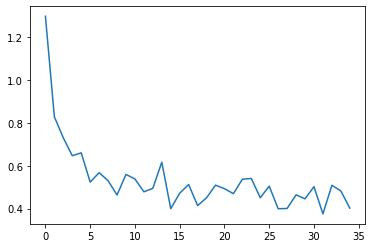

In [22]:
# plot losses
plt.plot(clf.history['loss'])

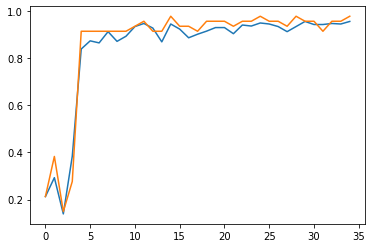

In [23]:
# plot auc
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

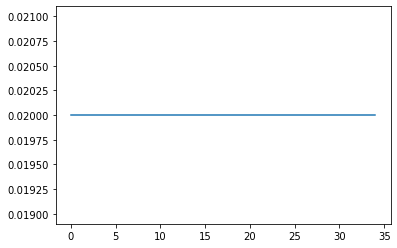

In [24]:
# plot learning rates
plt.plot(clf.history['lr'])

### Prediction

In [25]:
y_pred = clf.predict(X_test)

In [26]:
y_pred.shape

(66,)

In [27]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [28]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [29]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [30]:
#print(multiclass_roc_auc_score(y_test, y_pred))

In [31]:
X_test.shape

(66, 15)

In [32]:
y_test.shape

(66,)

Accuracy =  0.9848484848484849
-
[[33  0  0]
 [ 0 29  1]
 [ 0  0  3]]
-
              precision    recall  f1-score   support

    Diabetic       1.00      1.00      1.00        33
      Normal       1.00      0.97      0.98        30
 Prediabetic       0.75      1.00      0.86         3

    accuracy                           0.98        66
   macro avg       0.92      0.99      0.95        66
weighted avg       0.99      0.98      0.99        66

-


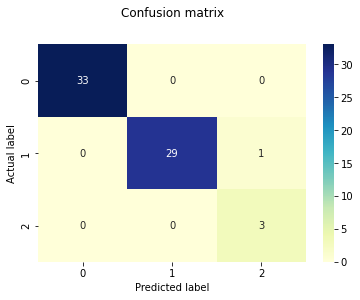

In [33]:
print('Accuracy = ', accuracy_score(y_test, y_pred))
print('-')
print(confusion_matrix(y_test,y_pred))
print('-')
print(classification_report(y_test,y_pred))
print('-')

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

#### Local Explainability and Masks

In [34]:
explain_matrix, masks = clf.explain(X_test)

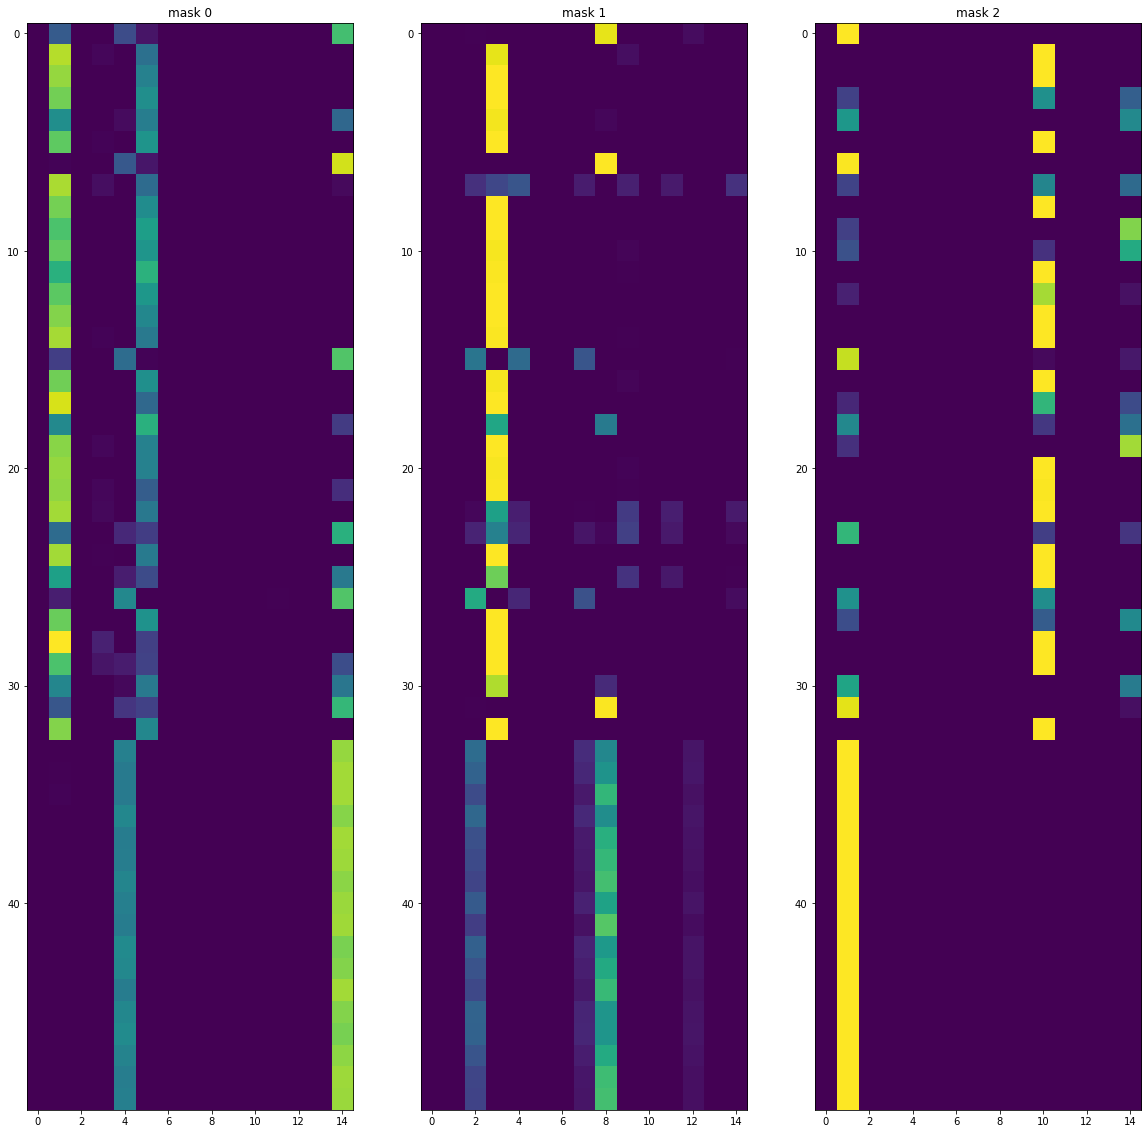

In [35]:
fig, axs = plt.subplots(1,3,figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")